# 👋🌍 QC Hack 2022

Project: Experimenting with small circuits to build and process 8x8 black-and-white images encoded using FRQI encoding scheme.


In [1]:
import qsharp
import qsharp.azure
targets = qsharp.azure.connect(
   resourceId="/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b",
   location="eastus")

Preparing Q# environment...
.Authenticated using Microsoft.Azure.Quantum.Authentication.TokenFileCredential


Connected to Azure Quantum workspace qchack-2022-b in location eastus.


Reference for the FRQI encoding: https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html#1.-The-FRQI-State

In [3]:
%%qsharp

// Our register has 1 qubit for color (|0> is blank, |1> is colored), then 3 qubits for the x coordinate, then 3 qubits for the y coordinate
// For example, if the pixel at coords (2,5) (0 indexed) is colored, then the state |1 010 101> will be part of the image superposition; if the pixel is blank, then we will have |0 010 101>

open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Convert;


// currently uses hardcoded size of 8x8
// coloredPixels: array of pairs of coordinates, for example [[0,0], [4,5]]: the pixels at position (0,0) and (4,5) are colored
operation BuildBasicFrqi(Color: Qubit, Coords:Qubit[], coloredPixels: Int[][]): Unit{
    ApplyToEach(H, Coords);
    for pixel in coloredPixels
    {
        let normalizedIndex = 8*pixel[0] + pixel[1];
        ControlledOnInt(normalizedIndex, X)(Coords, Color);
    }
}

We can study the size of the circuit for various inputs. To be able to do that, we have to create a parametrized operation which returns a Result[]

In [4]:
%%qsharp

open Microsoft.Quantum.Diagnostics;
operation BasicFrqi(coloredPixels: Int[][]): Result[]
{
    use q=Qubit[7]
    {
        BuildBasicFrqi(q[0], q[1..6], coloredPixels);
        return MultiM(q);
    }
}

Now we can simulate and estimate

In [5]:
BasicFrqi.simulate(coloredPixels=[[0,0],[1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]])


[0, 1, 1, 1, 0, 1, 0]

When we simulated BasicFrqi, we performed a measurement of all the qubits of the image. This causes the state of the image to collapse into a specific pixel, and the result of the measurement of the first qubit tells us if the pixel was colored or not.

In [6]:
BasicFrqi.estimate_resources(coloredPixels=[[0,0],[1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]])

{'CNOT': 720,
 'QubitClifford': 198,
 'R': 0,
 'Measure': 7,
 'T': 504,
 'Depth': 328,
 'Width': 11,
 'QubitCount': 11,
 'BorrowedWidth': 0}

In [7]:
BasicFrqi.estimate_resources(coloredPixels=[[0,0]])

{'CNOT': 90,
 'QubitClifford': 36,
 'R': 0,
 'Measure': 7,
 'T': 63,
 'Depth': 41,
 'Width': 11,
 'QubitCount': 11,
 'BorrowedWidth': 0}

We see that the circuit grows very rapidly; also even if we only allocate 7 qubits; the circuit actually needs 11. We suspect that the issue is with ControlledOnInt, which might be too generic for our case.

In [8]:
%%qsharp
operation BuildBasicFrqiAttemptTwo(Color: Qubit, Coords:Qubit[], coloredPixels: Int[][]): Unit{
    ApplyToEach(H, Coords);
    for pixel in coloredPixels
    {
        let normalizedIndex = 8*pixel[0] + pixel[1];
        let boolArray = IntAsBoolArray(normalizedIndex, 6);
        within
        {
            for (bit, qubi) in Zipped(Coords, boolArray)
            {
                CControlledCA(X)(qubi, bit);
            }
            ApplyToEachCA(X, Coords);
        }
        apply
        {
            Controlled(X)(Coords, Color);
        }
    }
}
operation BasicFrqiAttempt2(coloredPixels: Int[][]): Result[]
{
    use q=Qubit[7]
    {
        BuildBasicFrqiAttemptTwo(q[0], q[1..6], coloredPixels);

        return MultiM(q);
    }
}

In [9]:
BasicFrqiAttempt2(coloredPixels=[[0,0],[1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]])

[0, 0, 0, 0, 0, 1, 1]

In [10]:

BasicFrqiAttempt2.estimate_resources(coloredPixels=[[0,0],[1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]])

{'CNOT': 720,
 'QubitClifford': 294,
 'R': 0,
 'Measure': 7,
 'T': 504,
 'Depth': 328,
 'Width': 11,
 'QubitCount': 11,
 'BorrowedWidth': 0}

We can see that sadly the second attempt is worse than the first, and the width is still 11! Performing a controlled operation with 6 control qubits seems to not be feasible.

Let's try to make the encoding of the image to work for any size (our goal is to try out 4x4 images)

In [11]:
%%qsharp
open Microsoft.Quantum.Math;
operation BuildBasicFrqiGeneric(Color: Qubit, Coords:Qubit[], coloredPixels: Int[][]): Unit{
    ApplyToEach(H, Coords);

    let N = Length(Coords) / 2;
    for pixel in coloredPixels
    {
        // compute the index of the pixel
        let normalizedIndex = PowI(2, N)*pixel[0] + pixel[1];

        // toggle the color qubit for this particular pixel position
        ControlledOnInt(normalizedIndex, X)(Coords, Color);
    }
}

operation BasicFrqiGeneric(N: Int, coloredPixels: Int[][]): Result[]
{
    // we need 1 qubit for color and 2*N for a (2^N)*(2^N) image
    let requiredQubits = 1+2*N;
    use q=Qubit[requiredQubits]
    {
        BuildBasicFrqiGeneric(q[0], q[1..requiredQubits-1], coloredPixels);

        return MultiM(q);
    }
}

Let's try to build a 4x4 image now.

In [12]:
BasicFrqiGeneric.simulate(N=2, coloredPixels=[[2,3]])

[0, 1, 0, 1, 1]

In [13]:
BasicFrqiGeneric.estimate_resources(N=2, coloredPixels=[[0,0],[0,2],[1,1],[1,3],[2,0],[2,2],[3,1],[3,3]])

{'CNOT': 400,
 'QubitClifford': 116,
 'R': 0,
 'Measure': 5,
 'T': 280,
 'Depth': 184,
 'Width': 7,
 'QubitCount': 7,
 'BorrowedWidth': 0}

We can see that for generating a checkerboard pattern on a 4x4 square, we need to toggle 8 pixels, and the circuit is quite large. Let's try to write a smaller circuit that creates the same pattern.

If we look at the array of colored pixels, [[0,0],[0,2],[1,1],[1,3],[2,0],[2,2],[3,1],[3,3]], it is clear that the pixel is colored if and only if the sum of the 2 coordinates is even.
We can solve this with a small oracle.
Consider the sum of two numbers in binary notation, |101> and |010>. We can compute the sum, which would be |111>. The remainder of dividing 0b111 by 2 is the least significat bit, in our case 1, so the sum of |101> and |010> is not divisible by 2. 
Since we are only interested in the last bit, it is clear that we do not need to perform the entire sum, but only the sum of the least significant bit of both numbers. It is a known fact that addition modulo 2 of bits is equvalent to XOR, and XOR can be computed using CNOT gates.


In [14]:
%%qsharp
// x and y are the 2 numbers to be added
// pre: y is in |0> state
// post: y is in |0> state if sum of x and y is odd, |1> if sum is even
operation IsSumEvenOracle(x: Qubit[], y: Qubit[], target:Qubit): Unit
{
    CNOT(x[0], target);
    CNOT(y[0], target);
    // now target contains the XOR of x[0] and y[0]; so target is 1 if the sum is odd and 0 if the sum is even; we need the opposite, so we flip the target
    X(target);
}

In [15]:
%%qsharp
open Microsoft.Quantum.Math;
operation BuildBasicFrqiCheckerboard(Color: Qubit, Coords:Qubit[]): Unit{
    ApplyToEach(H, Coords);
    let N = Length(Coords)/2;
    IsSumEvenOracle(Coords[0..N-1], Coords[N..2*N-1], Color);
}

operation BasicFrqiCheckerboard(N: Int): Result[]
{
    // we need 1 qubit for color and 2*N for a (2^N)*(2^N) image
    let requiredQubits = 1+2*N;
    use q=Qubit[requiredQubits]
    {
        BuildBasicFrqiCheckerboard(q[0], q[1..requiredQubits-1]);

        return MultiM(q);
    }
}

In [16]:
BasicFrqiCheckerboard.estimate_resources(N=3)

{'CNOT': 2,
 'QubitClifford': 7,
 'R': 0,
 'Measure': 7,
 'T': 0,
 'Depth': 0,
 'Width': 7,
 'QubitCount': 7,
 'BorrowedWidth': 0}

Excellent result! :D The circuit is now so small, it is almost a waste to run it on quantum hardware.

Let's implement simple image processing routines, such as rotation. A 90 degrees rotation to the right is equivalent to the mapping (x,y) -> (y,x). This seems easy to implement in Q#


In [17]:
%%qsharp
operation RotateImageRight90(Color:Qubit, Coords:Qubit[]): Unit
{
    let N = Length(Coords)/2;
    for i in 0..N-1
    {
        SWAP(Coords[i], Coords[i+N]);
    }
}
operation RotateCheckerBoard(N:Int): Result[]
{
    // we need 1 qubit for color and 2*N for a (2^N)*(2^N) image
    let requiredQubits = 1+2*N;
    use q=Qubit[requiredQubits]
    {
        BuildBasicFrqiCheckerboard(q[0], q[1..requiredQubits-1]);
        RotateImageRight90(q[0], q[1..requiredQubits-1]);
        return MultiM(q);
    }
}

In [18]:
RotateCheckerBoard.estimate_resources(N=3)


{'CNOT': 11,
 'QubitClifford': 7,
 'R': 0,
 'Measure': 7,
 'T': 0,
 'Depth': 0,
 'Width': 7,
 'QubitCount': 7,
 'BorrowedWidth': 0}

Let's try to implement another clasic operation: let's shift the image one pixel to the right. We will wrap around the right edge of the image, so the last column becomes the first. This simply means adding 1 to the y coordinate of each pixel

In [20]:
%%qsharp
open Microsoft.Quantum.Arithmetic;
operation ShiftImageRight(Color:Qubit, Coords:Qubit[]): Unit
{
    let N = Length(Coords)/2;
    let yCoord = LittleEndian(Coords[N..2*N-1]);
    IncrementByInteger(1, yCoord);
}
operation RotateAndShiftCheckerBoard(N:Int): Result[]
{
    // we need 1 qubit for color and 2*N for a (2^N)*(2^N) image
    let requiredQubits = 1+2*N;
    use q=Qubit[requiredQubits]
    {
        BuildBasicFrqiCheckerboard(q[0], q[1..requiredQubits-1]);
        RotateImageRight90(q[0], q[1..requiredQubits-1]);
        ShiftImageRight(q[0], q[1..requiredQubits-1]);
        return MultiM(q);
    }
}

In [21]:
RotateAndShiftCheckerBoard.estimate_resources(N=3)

{'CNOT': 57,
 'QubitClifford': 23,
 'R': 0,
 'Measure': 7,
 'T': 31,
 'Depth': 21,
 'Width': 8,
 'QubitCount': 8,
 'BorrowedWidth': 0}

Let's see how our RotateAndShiftCheckerBoard performs on various targets.

In [22]:
qsharp.azure.target("ionq.simulator")

result = qsharp.azure.execute(RotateAndShiftCheckerBoard, N=3, shots=1000, jobName="IonqSimulator-RotateAndShift", timeout=240)

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.simulator
Submitting RotateAndShiftCheckerBoard to target ionq.simulator...
Job successfully submitted for 1000 shots.
   Job name: IonqSimulator-RotateAndShift
   Job ID: 29b6a6f5-1162-41bb-9bcd-8e2b43151881
Waiting up to 240 seconds for Azure Quantum job to complete...
[10:03:37] Current job status: Waiting
[10:03:42] Current job status: Waiting
[10:03:47] Current job status: Waiting
[10:03:52] Current job status: Waiting
[10:03:57] Current job status: Waiting
[10:04:02] Current job status: Waiting
[10:04:07] Current job status: Succeeded


In [23]:
print(result)

{'[0,0,0,0,0,0,0]': 0.015625, '[1,1,0,0,0,0,0]': 0.015625, '[0,0,1,0,0,0,0]': 0.015625, '[1,1,1,0,0,0,0]': 0.015625, '[0,0,0,1,0,0,0]': 0.015625, '[1,1,0,1,0,0,0]': 0.015625, '[0,0,1,1,0,0,0]': 0.015625, '[1,1,1,1,0,0,0]': 0.015625, '[1,0,0,0,1,0,0]': 0.015625, '[0,1,0,0,1,0,0]': 0.015625, '[1,0,1,0,1,0,0]': 0.015625, '[0,1,1,0,1,0,0]': 0.015625, '[1,0,0,1,1,0,0]': 0.015625, '[0,1,0,1,1,0,0]': 0.015625, '[1,0,1,1,1,0,0]': 0.015625, '[0,1,1,1,1,0,0]': 0.015625, '[0,0,0,0,0,1,0]': 0.015625, '[1,1,0,0,0,1,0]': 0.015625, '[0,0,1,0,0,1,0]': 0.015625, '[1,1,1,0,0,1,0]': 0.015625, '[0,0,0,1,0,1,0]': 0.015625, '[1,1,0,1,0,1,0]': 0.015625, '[0,0,1,1,0,1,0]': 0.015625, '[1,1,1,1,0,1,0]': 0.015625, '[1,0,0,0,1,1,0]': 0.015625, '[0,1,0,0,1,1,0]': 0.015625, '[1,0,1,0,1,1,0]': 0.015625, '[0,1,1,0,1,1,0]': 0.015625, '[1,0,0,1,1,1,0]': 0.015625, '[0,1,0,1,1,1,0]': 0.015625, '[1,0,1,1,1,1,0]': 0.015625, '[0,1,1,1,1,1,0]': 0.015625, '[0,0,0,0,0,0,1]': 0.015625, '[1,1,0,0,0,0,1]': 0.015625, '[0,0,1,0,0,0

In [24]:
qsharp.azure.target("quantinuum.hqs-lt-s2-apival")

result = qsharp.azure.execute(RotateAndShiftCheckerBoard, N=3, shots=1000, jobName="QuantinuumApival-RotateAndShift", timeout=240)

Loading package Microsoft.Quantum.Providers.Honeywell and dependencies...
Active target is now quantinuum.hqs-lt-s2-apival
Submitting RotateAndShiftCheckerBoard to target quantinuum.hqs-lt-s2-apival...
Job successfully submitted for 1000 shots.
   Job name: QuantinuumApival-RotateAndShift
   Job ID: 2d6b2e25-4e23-4e86-a99d-de632e10c986
Waiting up to 240 seconds for Azure Quantum job to complete...
[10:04:31] Current job status: Waiting
[10:04:36] Current job status: Waiting
[10:04:41] Current job status: Waiting
[10:04:46] Current job status: Waiting
[10:04:51] Current job status: Waiting
[10:04:56] Current job status: Succeeded


In [25]:
print(result)

{'[0,0,0,0,0,0,0]': 1.0000000000000007}


The quantinuum apival simulator performs (mostly) as expected: does not actually simulate anything, it just returns the state of all 0s. For some reason the measurement is a little bit greaater than 1 ?

In [26]:
qsharp.azure.target("quantinuum.hqs-lt-s2-sim")

quantinuum_result = qsharp.azure.execute(RotateAndShiftCheckerBoard, N=3, shots=1000, jobName="QuantinuumApival-RotateAndShift", timeout=240)

Loading package Microsoft.Quantum.Providers.Honeywell and dependencies...
Active target is now quantinuum.hqs-lt-s2-sim
Submitting RotateAndShiftCheckerBoard to target quantinuum.hqs-lt-s2-sim...
Job successfully submitted for 1000 shots.
   Job name: QuantinuumApival-RotateAndShift
   Job ID: f6d92b7a-d114-49f0-b426-2456be9e5891
Waiting up to 240 seconds for Azure Quantum job to complete...
[10:07:52] Current job status: Waiting
[10:07:57] Current job status: Waiting
[10:08:02] Current job status: Waiting
[10:08:07] Current job status: Waiting
[10:08:12] Current job status: Waiting
[10:08:17] Current job status: Waiting
[10:08:22] Current job status: Waiting
[10:08:27] Current job status: Waiting
[10:08:32] Current job status: Waiting
[10:08:37] Current job status: Waiting
[10:08:42] Current job status: Waiting
[10:08:47] Current job status: Waiting
[10:08:53] Current job status: Waiting
[10:08:58] Current job status: Waiting
[10:09:03] Current job status: Waiting
[10:09:08] Current j

In [27]:
print(quantinuum_result)

{'[1,0,1,0,0,0,1]': 0.001, '[1,0,1,1,1,0,1]': 0.01800000000000001, '[0,0,0,1,0,1,1]': 0.01800000000000001, '[1,0,0,0,1,0,1]': 0.012000000000000004, '[0,0,0,1,0,0,0]': 0.013000000000000005, '[0,1,1,1,0,0,0]': 0.001, '[0,1,1,0,1,1,1]': 0.016000000000000007, '[1,0,0,1,1,0,0]': 0.017000000000000008, '[1,1,1,0,0,1,1]': 0.017000000000000008, '[1,1,0,0,0,0,1]': 0.009000000000000001, '[0,1,1,1,1,1,1]': 0.01900000000000001, '[0,0,1,1,0,0,0]': 0.014000000000000005, '[0,1,1,1,1,0,0]': 0.016000000000000007, '[0,0,0,1,0,1,0]': 0.012000000000000004, '[1,1,1,0,0,1,0]': 0.013000000000000005, '[1,0,1,1,1,1,1]': 0.013000000000000005, '[0,0,0,0,0,1,1]': 0.017000000000000008, '[1,1,0,1,0,1,0]': 0.01800000000000001, '[0,0,1,0,0,1,0]': 0.012000000000000004, '[0,0,1,1,0,0,1]': 0.01900000000000001, '[1,1,0,1,1,0,1]': 0.002, '[0,0,1,0,0,0,1]': 0.014000000000000005, '[0,1,1,0,1,0,0]': 0.014000000000000005, '[0,1,0,0,1,1,0]': 0.013000000000000005, '[1,1,1,1,0,0,0]': 0.012000000000000004, '[0,0,1,1,0,1,0]': 0.012

In [28]:
qsharp.azure.target("ionq.qpu")

qpu_result = qsharp.azure.execute(RotateAndShiftCheckerBoard, N=3, shots=1000, jobName="IonQQpu-RotateAndShift", timeout=240)

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.qpu
Submitting RotateAndShiftCheckerBoard to target ionq.qpu...
Job successfully submitted for 1000 shots.
   Job name: IonQQpu-RotateAndShift
   Job ID: a266e991-2ffc-4a77-9202-0df9317f23a5
Waiting up to 240 seconds for Azure Quantum job to complete...
[10:12:37] Current job status: Waiting
[10:12:42] Current job status: Waiting
[10:12:47] Current job status: Waiting
[10:12:52] Current job status: Waiting
[10:12:57] Current job status: Waiting
[10:13:02] Current job status: Waiting
[10:13:07] Current job status: Waiting
[10:13:12] Current job status: Waiting
[10:13:17] Current job status: Waiting
[10:13:22] Current job status: Waiting
[10:13:27] Current job status: Waiting
[10:13:32] Current job status: Waiting
[10:13:38] Current job status: Waiting
[10:13:43] Current job status: Waiting
[10:13:48] Current job status: Waiting
[10:13:53] Current job status: Waiting
[10:13:58] Current job stat

TimeoutError: Timeout waiting for output

In [31]:
job_id = 'a266e991-2ffc-4a77-9202-0df9317f23a5'
status = qsharp.azure.status(job_id)
print(status)
ionq_qpu_result = qsharp.azure.output(job_id)
print(ionq_qpu_result)

{'id': 'a266e991-2ffc-4a77-9202-0df9317f23a5', 'name': 'IonQQpu-RotateAndShift', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b/job_management?microsoft_azure_quantum_jobid=a266e991-2ffc-4a77-9202-0df9317f23a5', 'provider': 'ionq', 'target': 'ionq.qpu', 'creation_time': '2022-04-10T10:12:32.6925898+00:00', 'begin_execution_time': '2022-04-10T10:23:44.249+00:00', 'end_execution_time': '2022-04-10T10:23:56.883+00:00', 'cost_estimate': '$0.00'}
{'[0,0,0,0,0,0,0]': 0.016, '[1,0,0,0,0,0,0]': 0.003, '[0,1,0,0,0,0,0]': 0.005, '[1,1,0,0,0,0,0]': 0.026, '[0,0,1,0,0,0,0]': 0.01, '[1,0,1,0,0,0,0]': 0.002, '[0,1,1,0,0,0,0]': 0.001, '[1,1,1,0,0,0,0]': 0.014, '[0,0,0,1,0,0,0]': 0.003, '[1,0,0,1,0,0,0]': 0.001, '[0,1,0,1,0,0,0]': 0.001, '[1,1,0,1,0,0,0]': 0.002, '[0,0,1,1,0,0,0]': 0.002, '[1,0,1,1,0,0,0]': 0.003, '[0,1,1,1,0,

Let's try to visualise these results. The functions below transforms the raw data and rebuilds the image based on the measurements.
As mentioned previously, each shot measure the entire image, and produces a color for a single pixel. By running the circuit many times, we can obtain sufficient information about each pixel to deduce an approximate state of it.
For example, if out of 15 results for the pixel (x,y), we obtained 10 times the state |0xy> and 5 times the state |1xy>, then the circuit is more likely to keep the pixel (x,y) as blank; if we obtain the state |1xy> every time (as in the simulations), then the pixel is more certainly colored.


In [45]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import json

def preprocess_data(measurement_data):
    # the data is of the form dict(measured_state:value)
    # we have to extract the values for both colors for each pixel
    # we store the mapping (x,y) -> (measurement_0, measurement_1), where measurement_0 is for the |0> state of color, and measurement_1 is for the |1> state
    pixel_map = {}
    for state, value in measurement_data.items():
        state_list = json.loads(state) #hackish, but should work
        color = state_list[0]
        #compute the pixel coordinates from the encoded state
        x = state_list[1] + 2*state_list[2] + 4*state_list[3]
        y = state_list[4] + 2*state_list[5] + 4*state_list[6]
        if color == 0:
            res = (value, 0)
        else:
            res = (0, value)
        if (x,y) in pixel_map:
            pixel_map[(x,y)] = (pixel_map[(x,y)][0] + res[0], pixel_map[(x,y)][1] + res[1])
        else:
            pixel_map[(x,y)] = res
    return pixel_map

def draw_pixel_map(pixel_map):
    N=8
    data = np.ones((N, N)) * np.nan

    fig, ax = plt.subplots(1, 1, tight_layout=True)
    my_cmap = matplotlib.colors.ListedColormap([(0.0, 0.0, 0.0),(0.33, 0.33, 0.33),(0.66, 0.66, 0.66),(1.0, 1.0, 1.0)])
    my_cmap.set_bad(color='w', alpha=0)
    
    for pixel, values in pixel_map.items():
        if values[0] < 0.005: # hardcoded minimum treshold
            data[pixel[0], pixel[1]] = 0    # black
        elif values[1] < 0.005:
            data[pixel[0], pixel[1]] = 3    # white
        elif values[1] < values[0]:
            data[pixel[0], pixel[1]] = 2    # light gray
        else:
            data[pixel[0], pixel[1]] = 1    # dark gray
        

    for x in range(N + 1):
        ax.axhline(x, lw=2, color='k', zorder=5)
        ax.axvline(x, lw=2, color='k', zorder=5)
    # draw the boxes
    ax.imshow(data, interpolation='none', cmap=my_cmap, extent=[0, N, 0, N], zorder=0)
    # turn off the axis labels
    ax.axis('off')



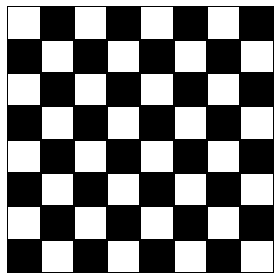

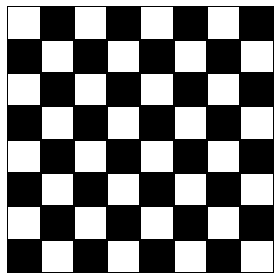

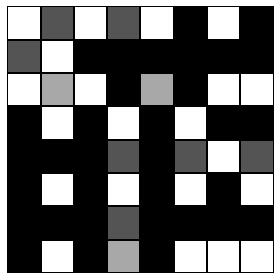

In [50]:
ionq_simulator = qsharp.azure.output('29b6a6f5-1162-41bb-9bcd-8e2b43151881') #ionq simulator

pixels = preprocess_data(ionq_simulator)
draw_pixel_map(pixels)

quantinuum_result = qsharp.azure.output('f6d92b7a-d114-49f0-b426-2456be9e5891')
pixels = preprocess_data(quantinuum_result)
draw_pixel_map(pixels)

ionq_qpu_result = qsharp.azure.output('a266e991-2ffc-4a77-9202-0df9317f23a5')
pixels = preprocess_data(ionq_qpu_result)
draw_pixel_map(pixels)



What nice images! The first one is the perfect simulation of ionq; The second simulation is on the (slightly) noisy quantinuum device, and it is still good.
The third run, on the ionq.qpu, is very noisy, but the image is still somewhat recognizable.